In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#Import CSV
#colnames, as they are not specified in DS
pd.options.display.max_columns = 50
colnames = ["id", "age", "gender", "education", "country", "ethnicity", 
            "neuroticism", "extraversion", "openness", "agreeableness",
           "conscientiousness", "impulsiveness", "sensation_seeking",
           "alcohol", "amphet", "amyl", "benzos", "caff", "cannabis",
           "choc", "coke", "crack", "ecstasy", "heroin", "ketamine",
           "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]
drugs = pd.read_csv('data/drug_consumption.csv', header = None, names = colnames, index_col = False)
drugs.head()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [2]:
# preprocessing (reverse transformation)
#relabelling from web source
age = {-0.07854: "25-34", -0.95197: "18-24", 2.59171: "65+", 1.82213: "55-64", 1.09449: "45-54", 0.49788: "35-45"}
gender = {0.48246: "Female", -0.48246: "Male"}
education = {-1.43719: "Left school at 17 years", -1.73790: "Left school at 16 years", -2.43591: "Left school before 16 years",
           0.45468: "University degree", -0.05921: "Professional certificate/ diploma", -0.61113: "Some college or university, no certificate or degree",
           -1.22751: "Left school at 18 years", 1.98437: "Doctorate degree", 1.16365: "Masters degree"}
country = {0.21128: "Republic of Ireland", -0.28519: "Other", -0.46841: "New Zealand", 0.24923: "Canada",
          -0.09765: "Australia", -0.57009: "USA", 0.96082: "UK"}
ethnicity = {-0.31685: "White", 0.11440: "Other", -0.22166: "Mixed-White/Black", 0.12600: "Mixed-White/Asian",
           1.90725: "Mixed-Black/Asian", -1.10702: "Black", -0.50212: "Asian"}

# rounding error must be corrected: website only contains 5 decimal numbers
drugs.age = round(drugs.age,5)
drugs.age = drugs.age.replace(age.keys(), age.values())
drugs.gender = round(drugs.gender, 5)
drugs.gender = drugs.gender.replace(gender.keys(), gender.values())
drugs.education = round(drugs.education, 5)
drugs.education = drugs.education.replace(education.keys(), education.values())
drugs.country = round(drugs.country, 5)
drugs.country = drugs.country.replace(country.keys(), country.values())
drugs.ethnicity = round(drugs.ethnicity, 5)
drugs.ethnicity = drugs.ethnicity.replace(ethnicity.keys(), ethnicity.values())

drugs.head()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,35-45,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,35-45,Male,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,35-45,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [3]:
#list of dicts for reverse transformation of the other variables
#these variables have more possible values, so it would be very time
#intense to do that manually as well
label_list = []
#extract informatioin from txt file created from web source
with open("data/drug_data-description.txt", "r") as file:
    data = file.readlines()
    for line in data:
        ### if line start with digit -> new variable section begins
        if line[0].isdigit():
            ### create new dict in list for each variable
            label_list.append(dict())
        ### only lines starting with <br> contain information
        if line[0:4] == "<br>":
            ### get clean numbers out of line
            numbers = line.split()[1:]
            #transform them from str to numeric
            for i in range(len(numbers)):
                if numbers[i].isdigit():
                    numbers[i] = int(numbers[i])
                else:
                    numbers[i] = float(numbers[i])
            ### append needed values to last (current) dict in list
            if len(numbers) == 6:
                numbers.pop(1)
                numbers.pop(3)
            if len(numbers) == 9:
                numbers.pop(1)
                numbers.pop(3)
                numbers.pop(5)
            for i in range(1, len(numbers), 2):
                label_list[len(label_list)-1][numbers[i]] = numbers[i-1]

## retransform variables according to dict
for i in range(len(label_list)):
    drugs.iloc[:,i+6] = round(drugs.iloc[:, i+6], 5)
    drugs.iloc[:,i+6] = drugs.iloc[:,i+6].replace(label_list[i].keys(), label_list[i].values())


In [4]:
#change data types
for i in range(1, 6):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
for i in range(6, 11):
    drugs[colnames[i]] = drugs[colnames[i]].astype("int32")

In [5]:
#########takes some time
#### removing "CL*"    
for i in range(13, len(colnames)):
    for j in range(0, len(drugs[colnames[i]])):
        drugs.iloc[j,i] = int(drugs.iloc[j,i][-1])
drugs.head()

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,35-45,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,5,2,0,2,6,0,5,0,0,0,0,0,0,0,0,0,2,0,0
1,2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,5,2,2,0,6,4,6,3,0,4,0,2,0,2,3,0,4,0,0
2,3,35-45,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,6,0,0,0,6,3,4,0,0,0,0,0,0,0,0,1,0,0,0
3,4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,4,0,0,3,5,2,4,2,0,0,0,2,0,0,0,0,2,0,0
4,5,35-45,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,4,1,1,0,6,3,6,0,0,1,0,0,1,0,0,2,2,0,0


In [6]:
for i in range(13, len(colnames)):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
print(drugs.info())
print(drugs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
id                   1885 non-null int64
age                  1885 non-null category
gender               1885 non-null category
education            1885 non-null category
country              1885 non-null category
ethnicity            1885 non-null category
neuroticism          1885 non-null int32
extraversion         1885 non-null int32
openness             1885 non-null int32
agreeableness        1885 non-null int32
conscientiousness    1885 non-null int32
impulsiveness        1885 non-null float64
sensation_seeking    1885 non-null float64
alcohol              1885 non-null category
amphet               1885 non-null category
amyl                 1885 non-null category
benzos               1885 non-null category
caff                 1885 non-null category
cannabis             1885 non-null category
choc                 1885 non-null category
coke                 1885 non-nul

## 3 Statistical Analysis

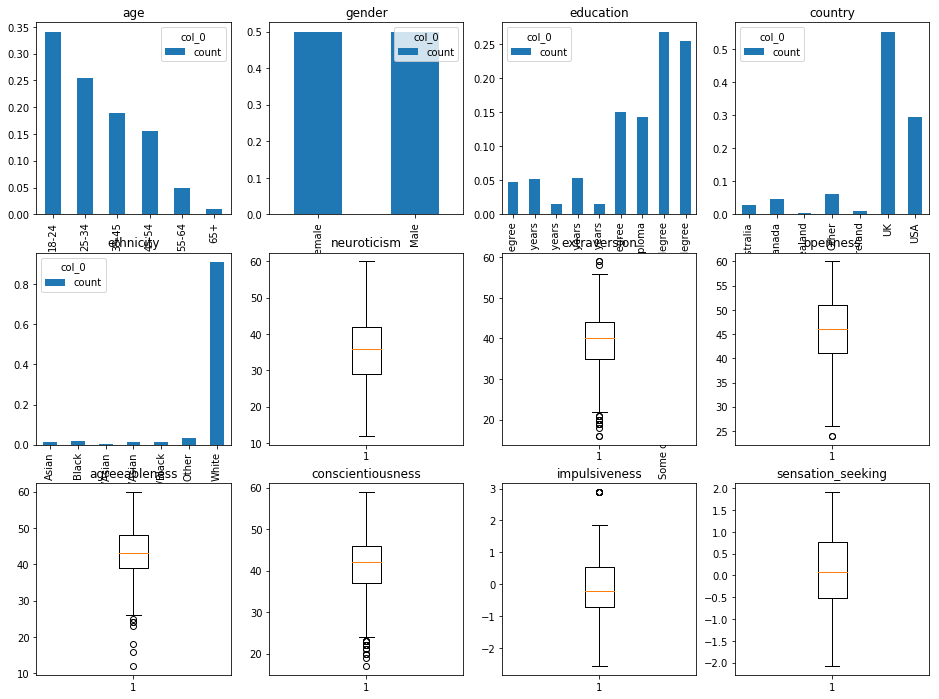

In [7]:
fig, axlist = plt.subplots(3,4,figsize=(16,12))
variable = 1
for row in range(0,3):
    for i in range(0,4):
        if drugs[colnames[variable]].dtype == "int32" or drugs[colnames[variable]].dtype == "float64":
            axlist[row][i].boxplot(drugs[colnames[variable]])
            axlist[row][i].set_title(colnames[variable])
        else:
            tab = pd.crosstab(drugs[colnames[variable]], columns="count")
            rel_tab = tab/tab.sum()
            rel_tab.plot(kind = "bar", ax = axlist[row][i])
            axlist[row][i].set_title(colnames[variable])
        variable += 1

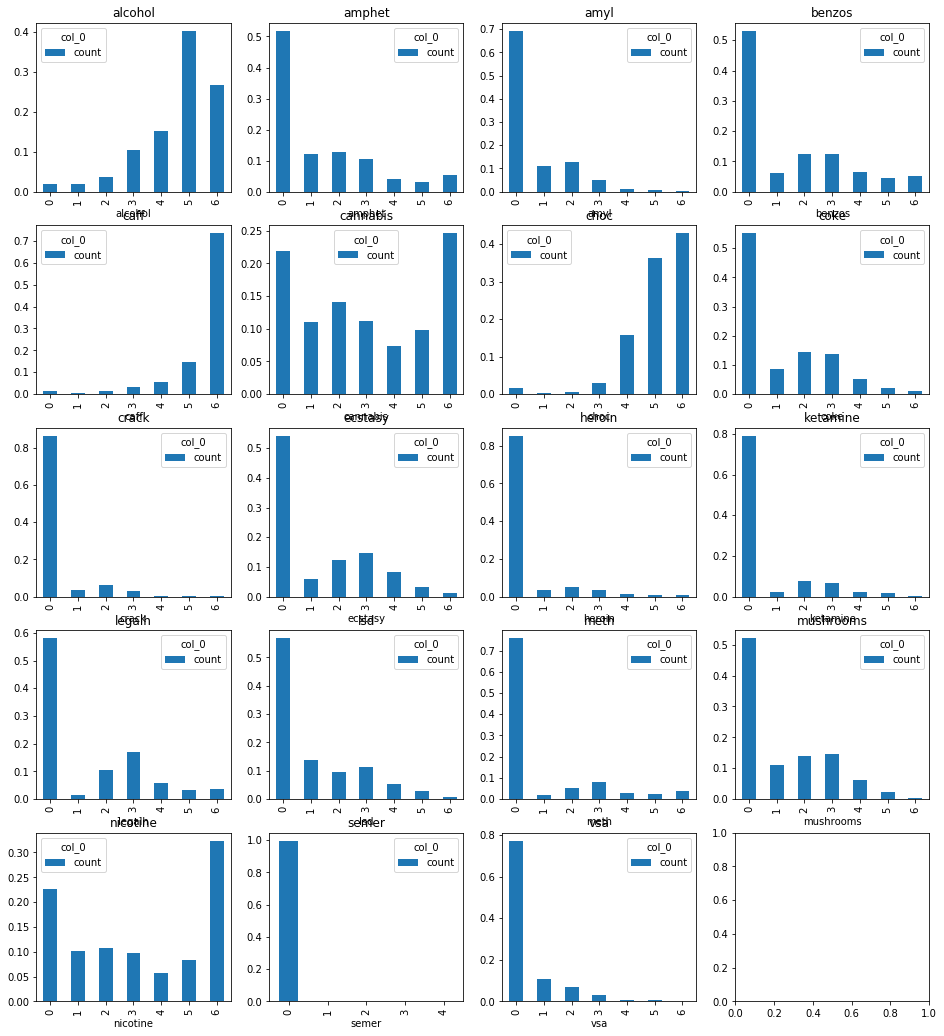

In [24]:
fig, axlist = plt.subplots(5,4,figsize=(16,18))
for row in range(0,5):
    for i in range(0,4):
        tab = pd.crosstab(drugs[colnames[variable]], columns="count")
        rel_tab = tab/tab.sum()
        rel_tab.plot(kind = "bar", ax = axlist[row][i])
        axlist[row][i].set_title(colnames[variable])
        if variable == 31:
            break
        variable += 1

In [7]:
drugs.isna().sum() # The number of missing values per Attribute (column)

id                   0
age                  0
gender               0
education            0
country              0
ethnicity            0
neuroticism          0
extraversion         0
openness             0
agreeableness        0
conscientiousness    0
impulsiveness        0
sensation_seeking    0
alcohol              0
amphet               0
amyl                 0
benzos               0
caff                 0
cannabis             0
choc                 0
coke                 0
crack                0
ecstasy              0
heroin               0
ketamine             0
legalh               0
lsd                  0
meth                 0
mushrooms            0
nicotine             0
semer                0
vsa                  0
dtype: int64

In [8]:
drugs.shape # Check dimensions

(1885, 32)

In [9]:
drugs.iloc[:,1:].describe() #without id

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400
max,60.000000,59.000000,60.000000,60.000000,59.000000,2.901610,1.921730


There is no statistical summary for categorical data. We can get a summary of the categorical variables by passing only those columns to describe():

In [8]:
categorical = drugs.dtypes[drugs.dtypes == "category"].index #gives list of attributes that are categorical
drugs[categorical].describe()

,age,gender,education,country,ethnicity,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,6,2,9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,18-24,Male,"Some college or university, no certificate or ...",UK,White,5,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,6,0,0
freq,643,943,506,1044,1720,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


The categorical variable summary shows the count, the number of unique categories, the most frequently occurring value and the number of occurrences of the most frequent value.

** age:
The most frequent value is "18-24". It is repeated 643 times.

** gender:
We can see from the table that the number of female is higher than the number of males. 

** country:
UK has the highest frequntative value among the surveyed countries.  



This is a correlation matrix which is a table showing correlation coefficients between variables.

In [11]:
#list of proportional frequency tables
prop_tables = []
for variable in categorical:
    tab = pd.crosstab(drugs[variable], columns="count")
    rel_tab = tab/tab.sum()
    prop_tables.append(rel_tab)

print(categorical)

for i in [0, 2, 5, 14]:
    print(prop_tables[i])
    print()
    

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')
col_0     count
age            
18-24  0.341114
25-34  0.255172
35-45  0.188859
45-54  0.155968
55-64  0.049337
65+    0.009549

col_0                                                  count
education                                                   
Doctorate degree                                    0.047215
Left school at 16 years                             0.052520
Left school at 17 years                             0.015915
Left school at 18 years                             0.053050
Left school before 16 years                         0.014854
Masters degree                                      0.150133
Professional certificate/ diploma                   0.143236
Some college or university, no cer

## Testing Algorithms

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

from sklearn.metrics import recall_score, precision_score

### The proper implementation of the experiments
This is what will be included in our report

In [13]:
### filter relevant features and target variable
Xdata = drugs.iloc[:,1:13]
Ydata = drugs.cannabis

### kNN

In [79]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)

### Experiment 1: k-range 2:100, algorithm = brute, weights = uniform, source
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="uniform", algorithm = "brute")
    scores = cross_validate(knn, Xdata_dummy, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

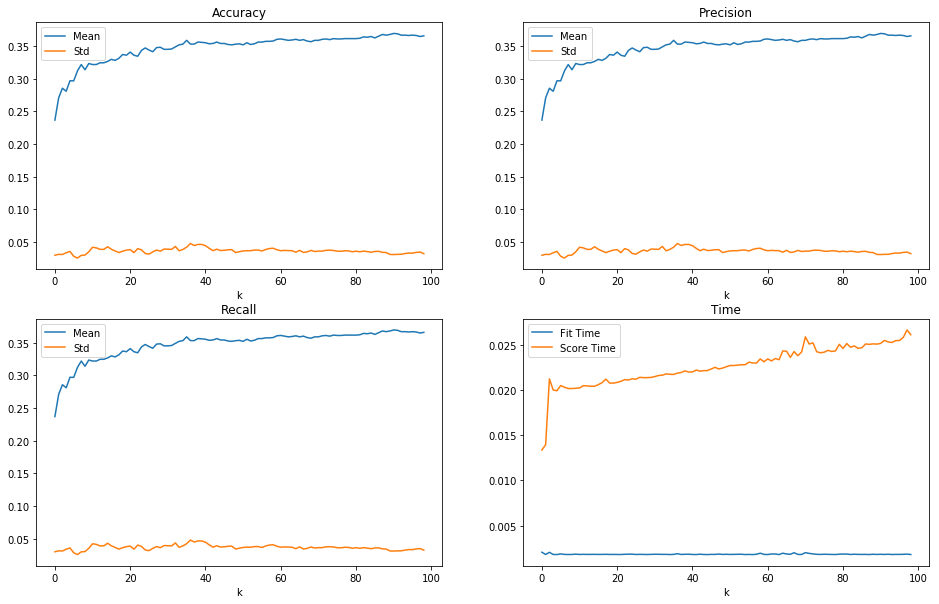

In [64]:
### Summary Plot for Experiment 1
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [65]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)

### Experiment 2: k-range 2:100, algorithm = brute, weights = distance, source
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="distance", algorithm = "brute")
    scores = cross_validate(knn, Xdata_dummy, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

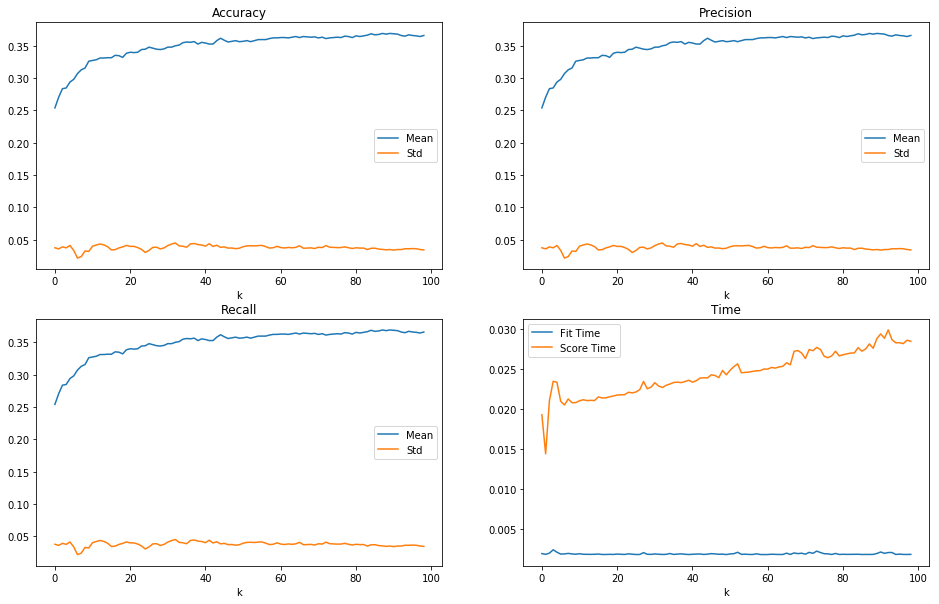

In [66]:
### Summary Plot for Experiment 2
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [69]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 3: k-range 2:100, algorithm = brute, weights = uniform, scale
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="uniform", algorithm = "brute")
    scores = cross_validate(knn, X_minmax, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

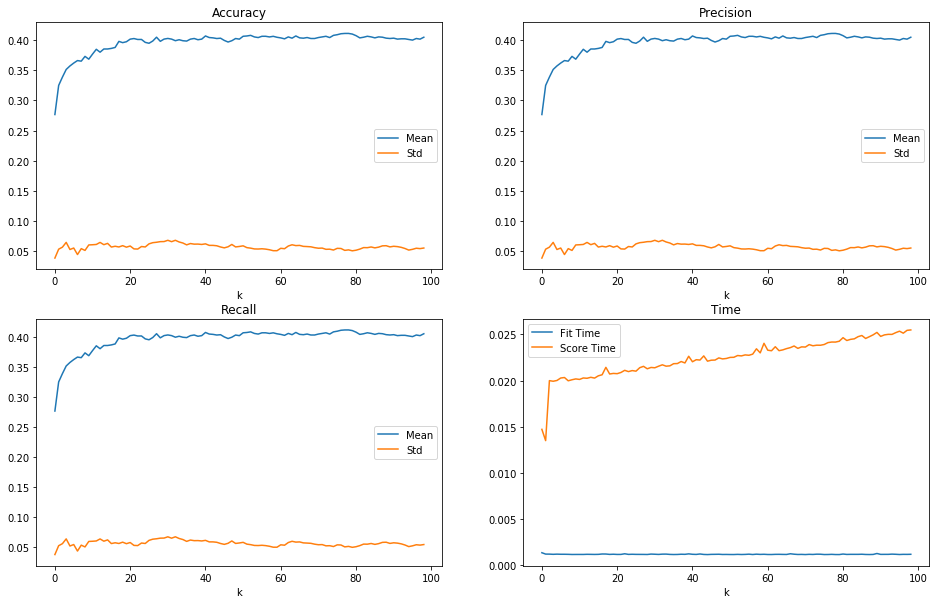

In [70]:
### Summary Plot for Experiment 3
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [71]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 4: k-range 2:100, algorithm = brute, weights = distance, scale
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="distance", algorithm = "brute")
    scores = cross_validate(knn, X_minmax, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

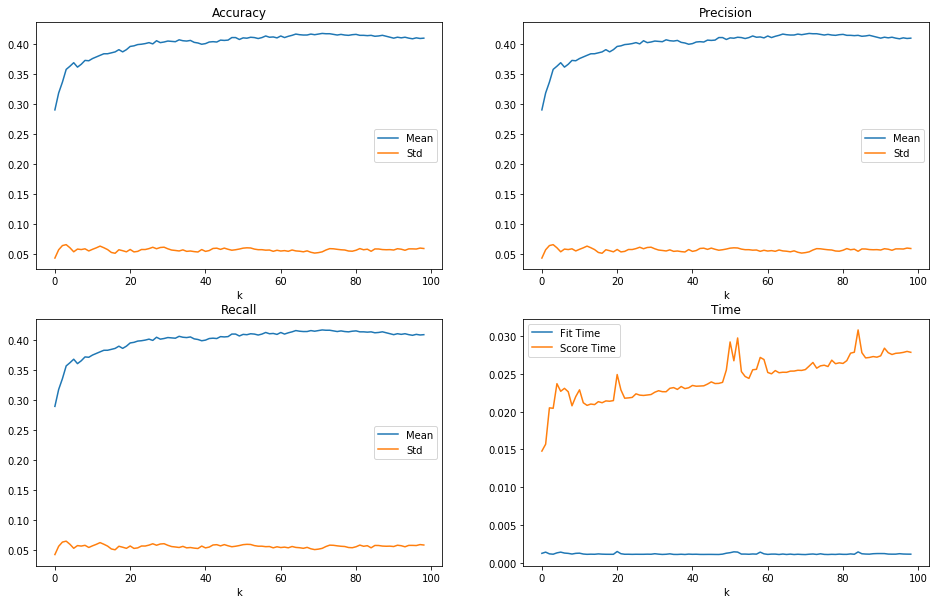

In [72]:
### Summary Plot for Experiment 4
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [73]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)

### Experiment 5: k-range 2:100, algorithm = kd_tree, weights = uniform, source
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="uniform", algorithm = "kd_tree")
    scores = cross_validate(knn, Xdata_dummy, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

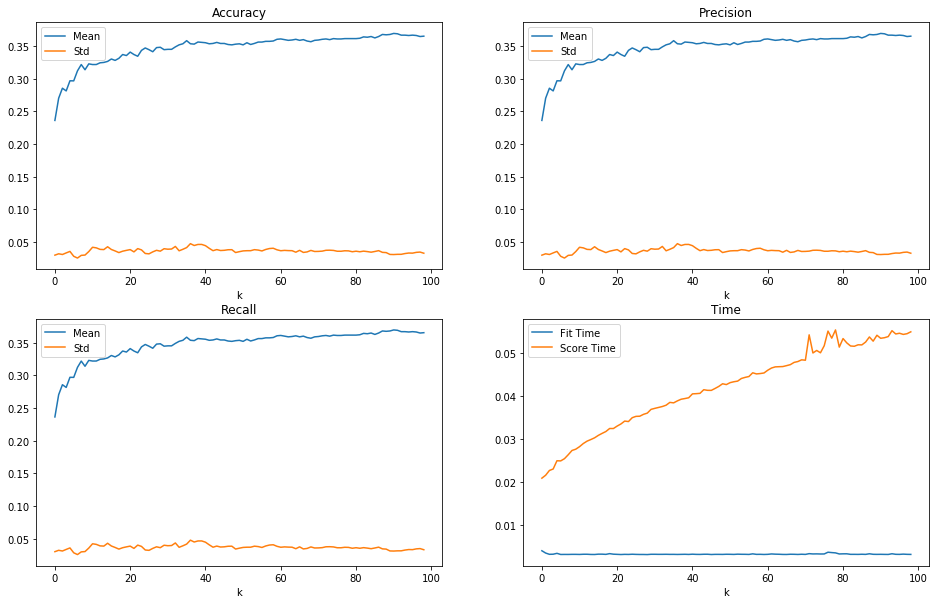

In [74]:
### Summary Plot for Experiment 5
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [75]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 6: k-range 2:100, algorithm = kd_tree, weights = uniform, scale
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="uniform", algorithm = "kd_tree")
    scores = cross_validate(knn, X_minmax, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

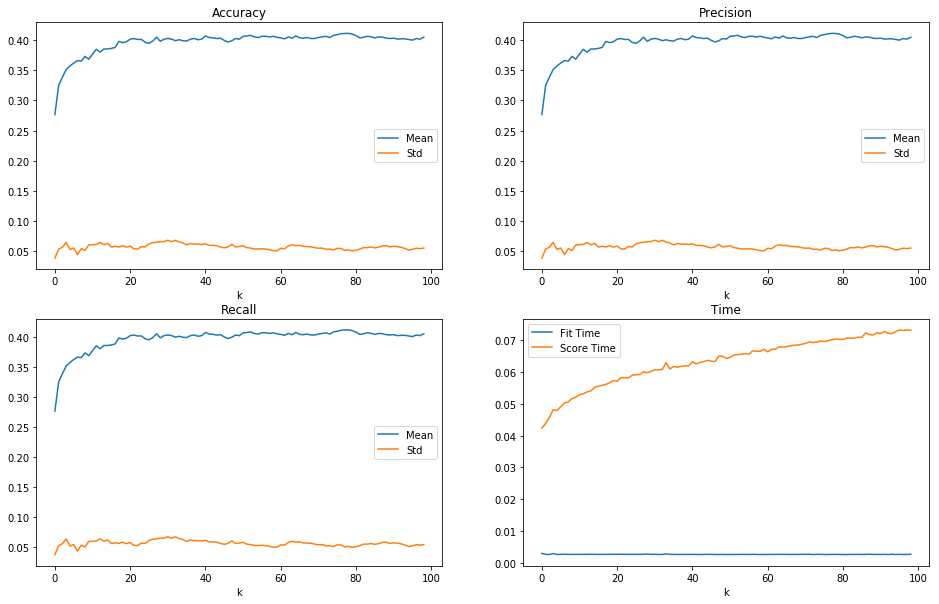

In [76]:
### Summary Plot for Experiment 6
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

In [77]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 7: k-range 2:100, algorithm = kd_tree, weights = distance, scale
accuracy_mean = []
accuracy_std = []
fit_time = []
score_time = []
precision_mean = []
precision_std = []
recall_mean = []
recall_std = []
### metrics for our analysis
scoring = ["accuracy", "precision_micro", "recall_micro"]
for i in range(2,101):
    knn = KNeighborsClassifier(i, weights="distance", algorithm = "kd_tree")
    scores = cross_validate(knn, X_minmax, Ydata, cv=10, scoring=scoring, return_train_score=False)
    accuracy_mean.append(scores["test_accuracy"].mean())
    accuracy_std.append(scores["test_accuracy"].std())
    fit_time.append(scores["fit_time"].mean())
    score_time.append(scores["score_time"].mean())
    precision_mean.append(scores["test_precision_micro"].mean())
    precision_std.append(scores["test_precision_micro"].std())
    recall_mean.append(scores["test_recall_micro"].mean())
    recall_std.append(scores["test_recall_micro"].std())

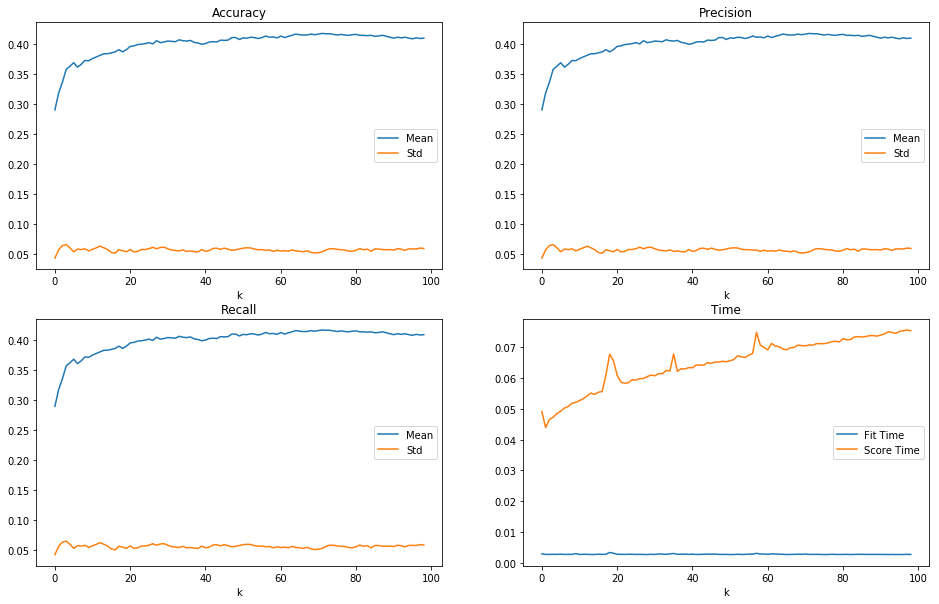

In [78]:
### Summary Plot for Experiment 7
plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(accuracy_mean)
plt.plot(accuracy_std)
plt.title("Accuracy")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,2)
plt.plot(precision_mean)
plt.plot(precision_std)
plt.title("Precision")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,3)
plt.plot(recall_mean)
plt.plot(recall_std)
plt.title("Recall")
plt.xlabel("k")
plt.legend(("Mean", "Std"))
plt.subplot(2,2,4)
plt.plot(fit_time)
plt.plot(score_time)
plt.title("Time")
plt.xlabel("k")
plt.legend(("Fit Time", "Score Time"))

### Naive Bayes

In [14]:
### numerical data is needed
#discretize continuis variables
for i in range(5,Xdata.shape[1]):
    quantiles = Xdata.iloc[:,i].quantile([0,0.2,0.4,0.6,0.8,1])
    Xdata.iloc[:,i] = pd.cut(Xdata.iloc[:,i], quantiles, include_lowest=True)

Xdata_lable = Xdata    
    
for i in range(0,12):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata.iloc[:,i])

mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

scoring = ["accuracy", "precision_micro", "recall_micro"]

scores_mnb = cross_validate(mnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
scores_bnb = cross_validate(bnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
scores_gnb = cross_validate(gnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)

In [18]:
### Function for summary plot
def plot_summary(scores_mnb):
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(scores_mnb["test_accuracy"])
    plt.axhline(scores_mnb["test_accuracy"].mean(), color= "orange")
    plt.title("Accuracy")
    plt.subplot(2,2,2)
    plt.plot(scores_mnb["test_precision_micro"])
    plt.axhline(scores_mnb["test_precision_micro"].mean(), color= "orange")
    plt.title("Precision")
    plt.subplot(2,2,3)
    plt.plot(scores_mnb["test_recall_micro"])
    plt.axhline(scores_mnb["test_recall_micro"].mean(), color= "orange")
    plt.title("Recall")
    plt.subplot(2,2,4)
    plt.plot(scores_mnb["fit_time"])
    plt.plot(scores_mnb["score_time"])
    plt.title("Time")
    plt.legend(("Fit Time", "Score Time"))

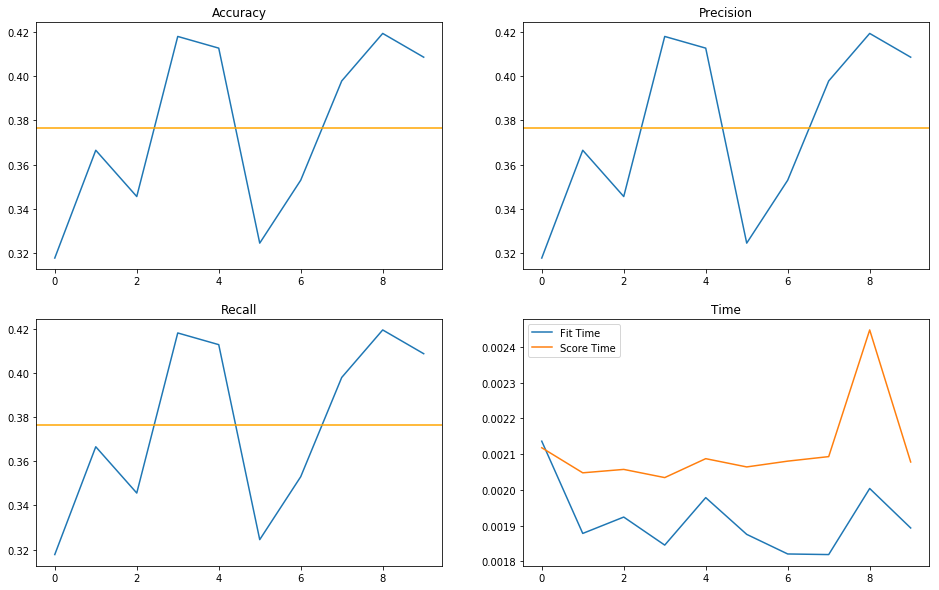

In [19]:
plot_summary(scores_mnb)

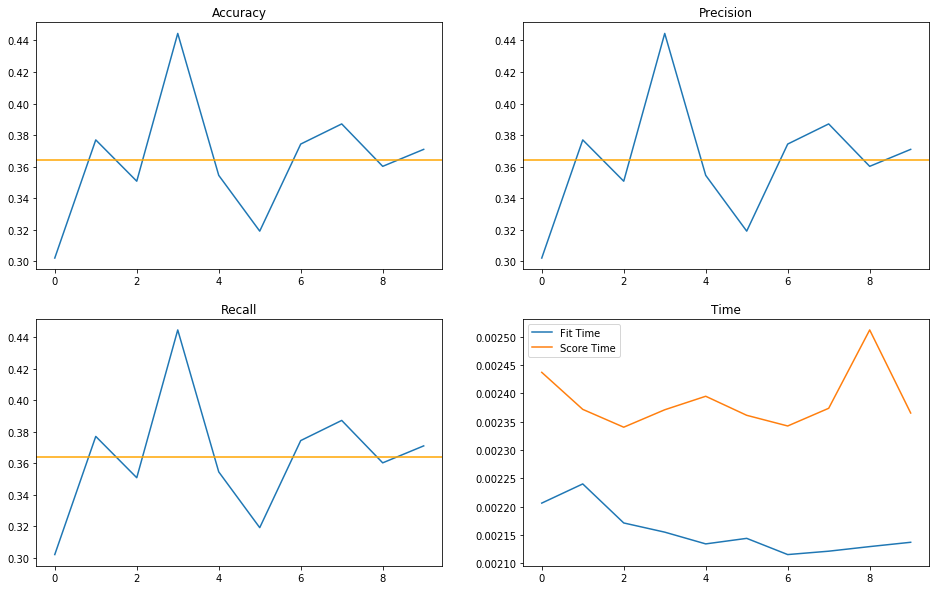

In [20]:
plot_summary(scores_bnb)

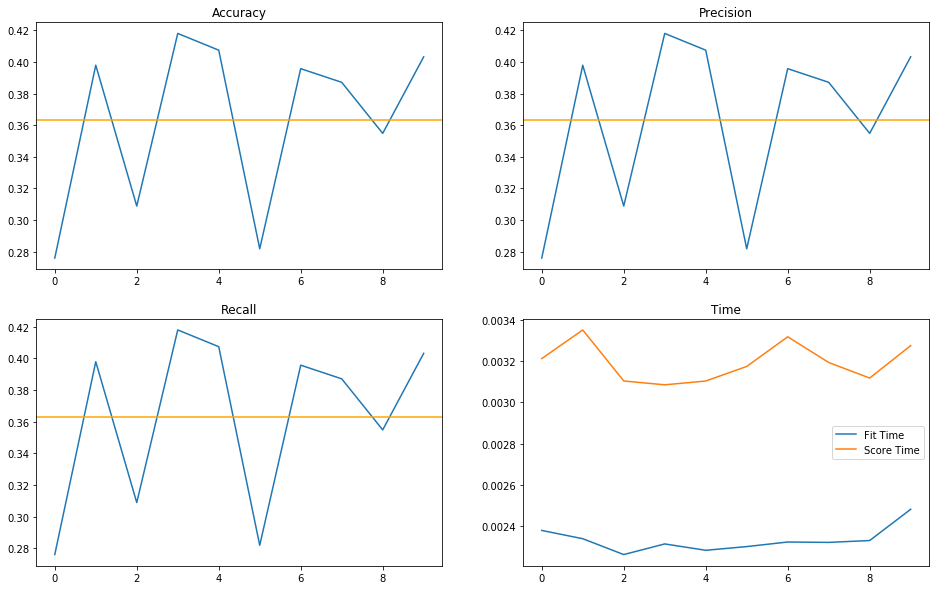

In [21]:
plot_summary(scores_gnb)

### Random Forest

In [59]:
def test_rfc(Xdata, Ydata, criterion = "gini", min_samples_split = 2, min_samples_leaf = 1):
    scoring = ["accuracy", "precision_micro", "recall_micro"]
    accuracy_mean = []
    accuracy_std = []
    fit_time = []
    score_time = []
    precision_mean = []
    precision_std = []
    recall_mean = []
    recall_std = []
    
    xaxis = []
    
    for i in range(10, 201, 10):
        xaxis.append(i)
    
    for i in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=i, criterion=criterion, min_samples_split=min_samples_split)
        scores = cross_validate(rfc, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
    
        accuracy_mean.append(scores["test_accuracy"].mean())
        accuracy_std.append(scores["test_accuracy"].std())
        fit_time.append(scores["fit_time"].mean())
        score_time.append(scores["score_time"].mean())
        precision_mean.append(scores["test_precision_micro"].mean())
        precision_std.append(scores["test_precision_micro"].std())
        recall_mean.append(scores["test_recall_micro"].mean())
        recall_std.append(scores["test_recall_micro"].std())
    
    ### Summary Plot
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(xaxis, accuracy_mean)
    plt.plot(xaxis, accuracy_std)
    plt.title("Accuracy")
    plt.xlabel("Number of estimators")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,2)
    plt.plot(xaxis, precision_mean)
    plt.plot(xaxis, precision_std)
    plt.title("Precision")
    plt.xlabel("Number of estimators")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,3)
    plt.plot(xaxis, recall_mean)
    plt.plot(xaxis, recall_std)
    plt.title("Recall")
    plt.xlabel("Number of estimators")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,4)
    plt.plot(xaxis, fit_time)
    plt.plot(xaxis, score_time)
    plt.title("Time")
    plt.xlabel("Number of estimators")
    plt.legend(("Fit Time", "Score Time"))

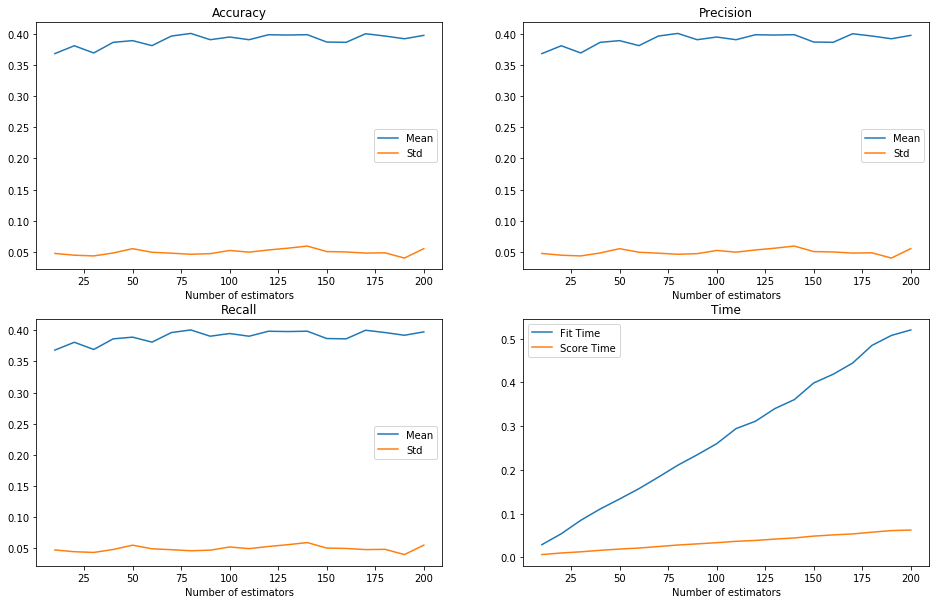

In [58]:
Xdata_lable = Xdata

for i in range(0,5):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata.iloc[:,i])
    

test_rfc(Xdata_lable, Ydata, "gini", 2)

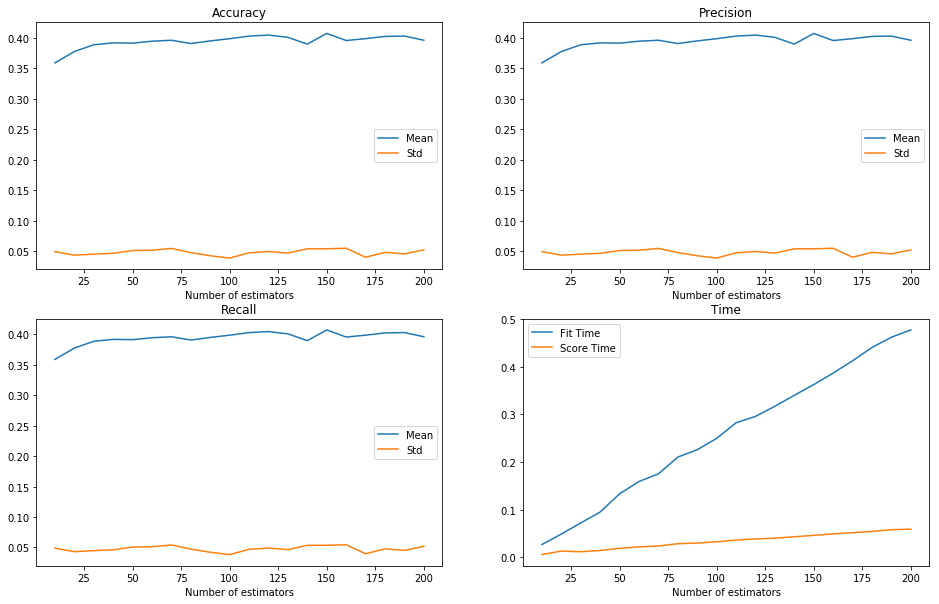

In [63]:
test_rfc(Xdata_lable, Ydata, "gini", 5)

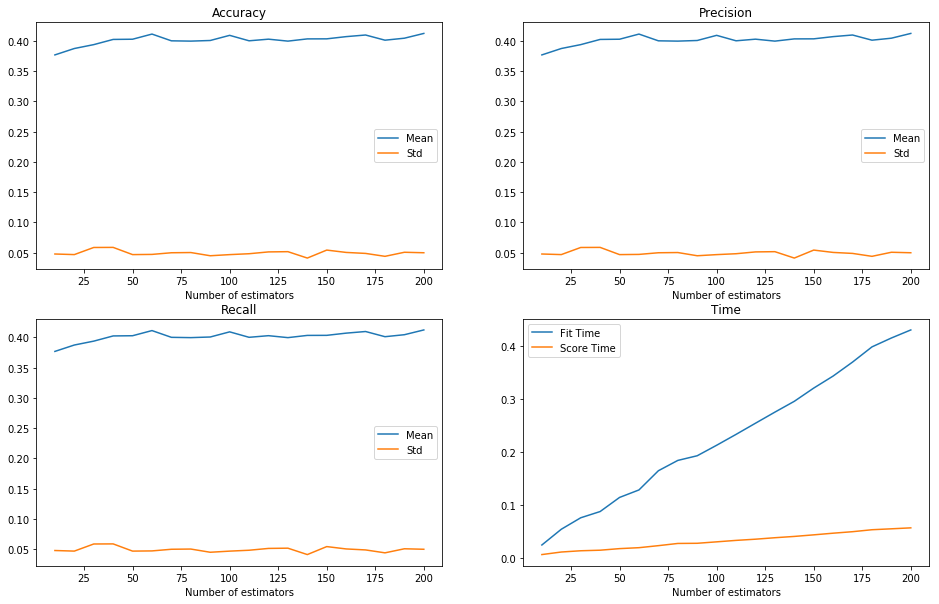

In [60]:
test_rfc(Xdata_lable, Ydata, "gini", 10)

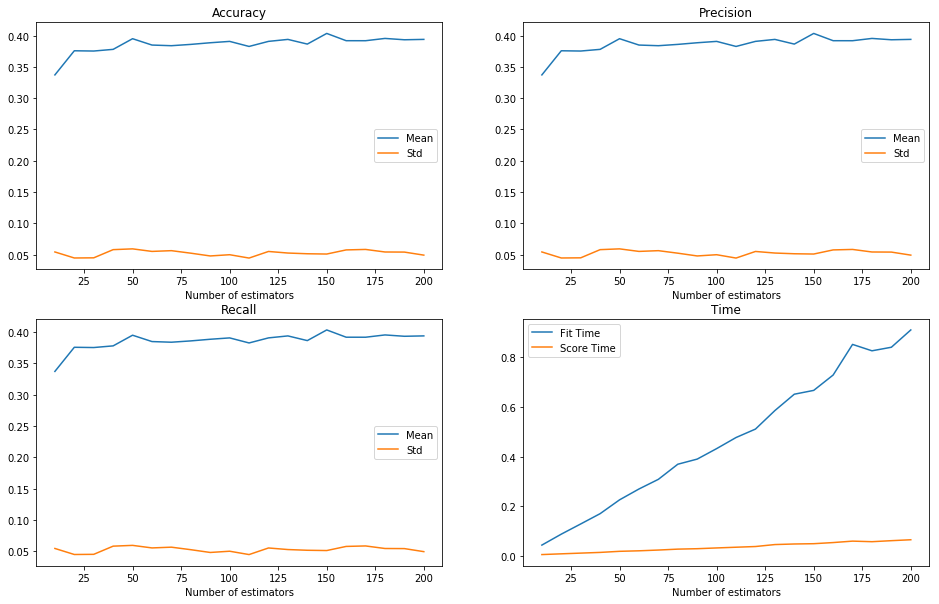

In [65]:
test_rfc(Xdata_lable, Ydata, "entropy", 2)

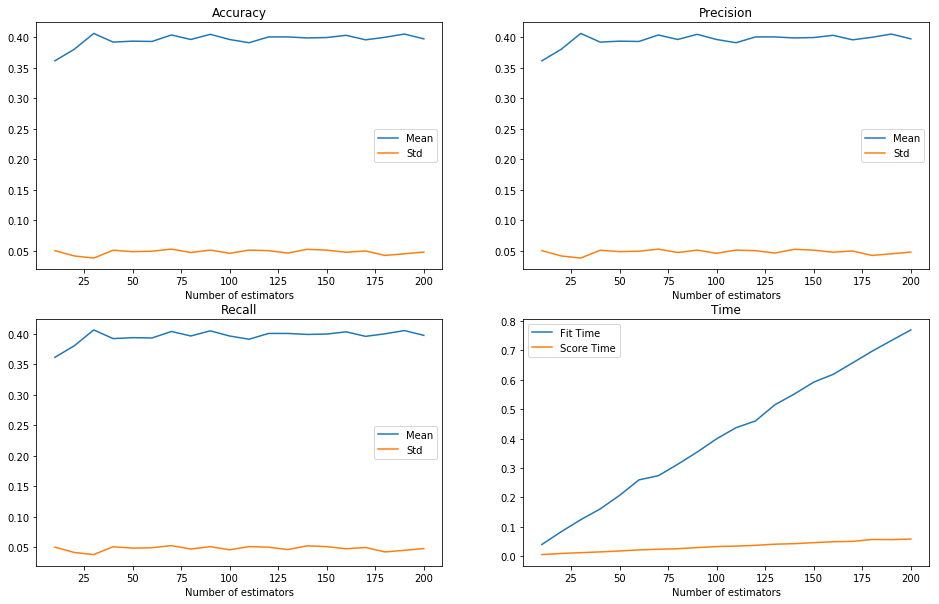

In [66]:
test_rfc(Xdata_lable, Ydata, "entropy", 5)

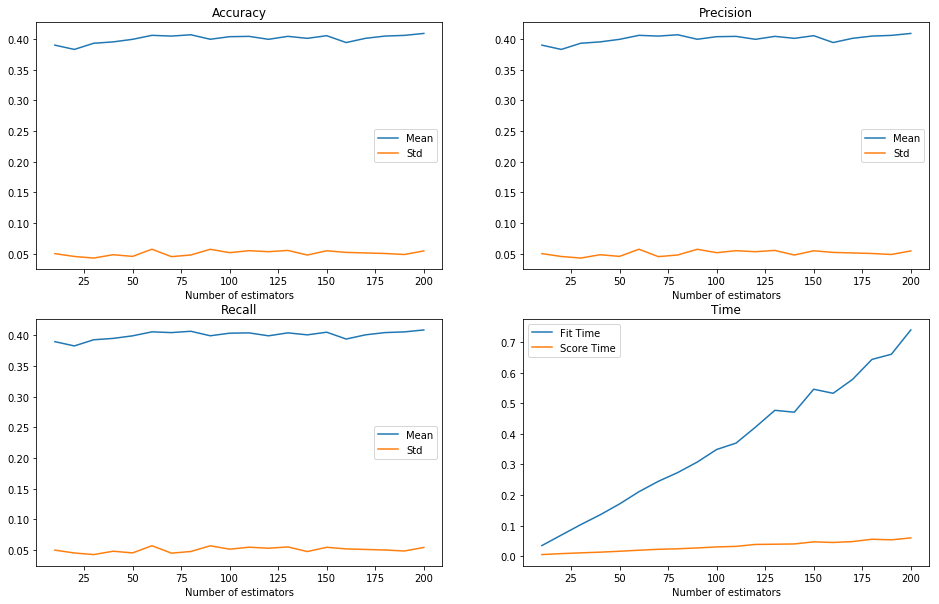

In [67]:
test_rfc(Xdata_lable, Ydata, "entropy", 10)

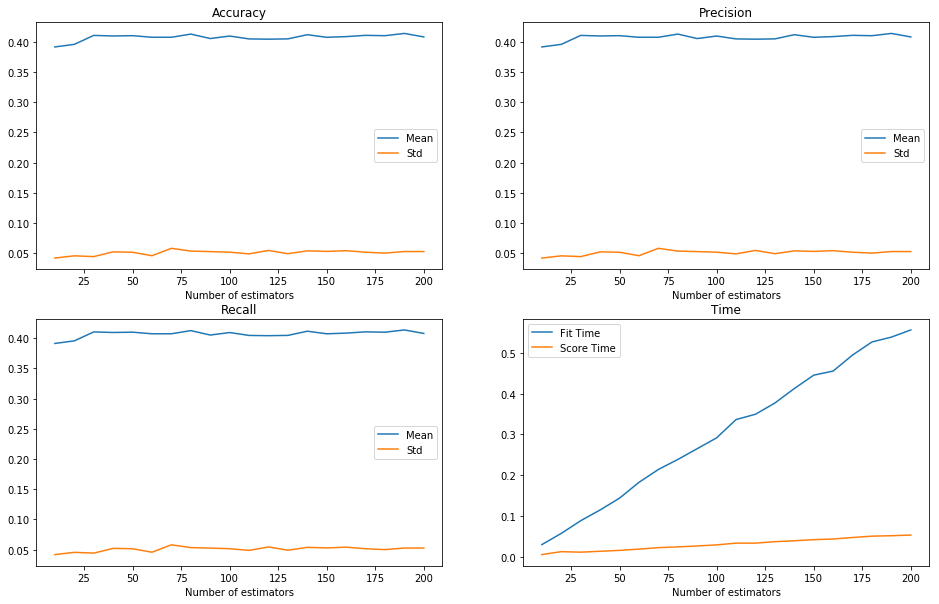

In [68]:
test_rfc(Xdata_lable, Ydata, "entropy", 20)

In [ ]:
###### STOP

### This is only experimenting for learning

#### knn

(1885, 12)
(1885,)


Text(0.5,1,'Time')

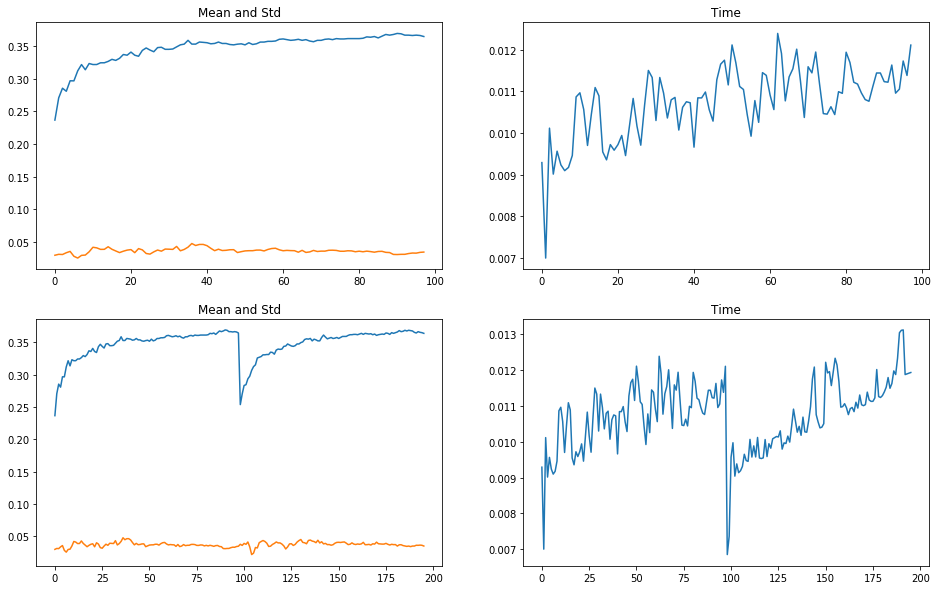

In [40]:
############################## Testing knn on cannabis
Xdata = drugs.iloc[:,1:13]
Xdata.head()
Ycannabis = drugs.cannabis
print(Xdata.shape)
print(Ycannabis.shape)

### one hot encoding
Xdata = pd.get_dummies(Xdata)


### create test data

#XYcannabis = pd.concat([Xdata, Ycannabis], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ycannabis, random_state = 0)



### create modle
#from sklearn.neighbors import KNeighborsClassifier
#classifier = KNeighborsClassifier(15, algorithm = "brute")
#classifier.fit(X_train, y_train)
#sum(classifier.predict(X_test) == y_test)/len(y_test)

### compare diff models

### find number of k
results_mean = []
results_std = []
time_taken = []
for i in range(2, 100):
    classifier = KNeighborsClassifier(i, algorithm = "brute")
    start = time.time()
    scores = cross_val_score(classifier, Xdata, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)

plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(results_mean)
plt.plot(results_std)
plt.title("Mean and Std")
plt.subplot(2,2,2)
plt.plot(time_taken)
plt.title("Time")

for i in range(2, 100):
    classifier = KNeighborsClassifier(i, algorithm = "brute", weights = 'distance')
    start = time.time()
    scores = cross_val_score(classifier, Xdata, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)

plt.subplot(2,2,3)
plt.plot(results_mean)
plt.plot(results_std)
plt.title("Mean and Std")
plt.subplot(2,2,4)
plt.plot(time_taken)
plt.title("Time")

Text(0.5,1,'Time')

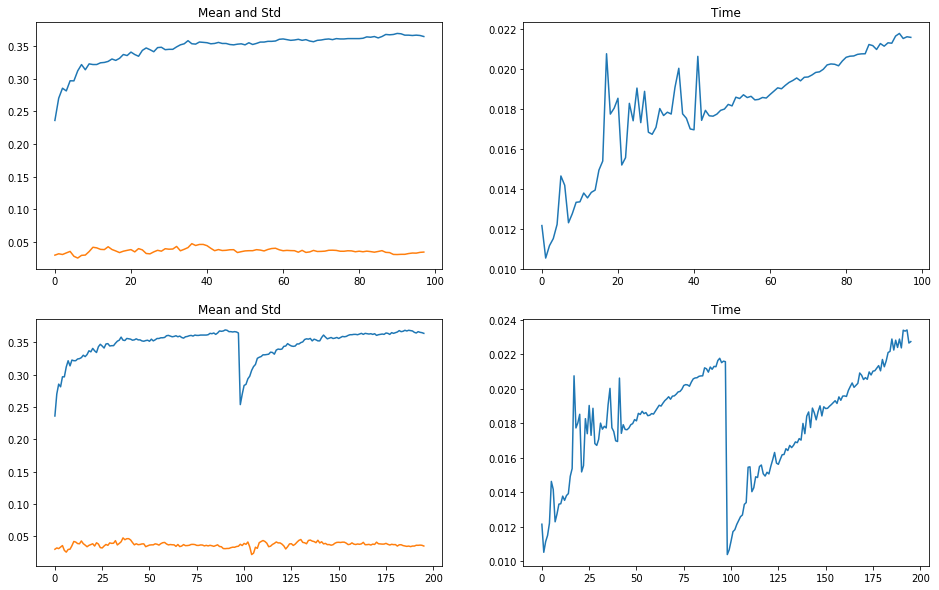

In [10]:
for i in range(2, 100):
    classifier = KNeighborsClassifier(i, algorithm = "kd_tree", weights = 'uniform')
    start = time.time()
    scores = cross_val_score(classifier, Xdata, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)

plt.figure(figsize=(16, 10))
plt.subplot(2,2,1)
plt.plot(results_mean)
plt.plot(results_std)
plt.title("Mean and Std")
plt.subplot(2,2,2)
plt.plot(time_taken)
plt.title("Time")

for i in range(2, 100):
    classifier = KNeighborsClassifier(i, algorithm = "kd_tree", weights = 'distance')
    start = time.time()
    scores = cross_val_score(classifier, Xdata, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)
    
plt.subplot(2,2,3)
plt.plot(results_mean)
plt.plot(results_std)
plt.title("Mean and Std")
plt.subplot(2,2,4)
plt.plot(time_taken)
plt.title("Time")

##### With Scaling

Text(0.5,1,'Time')

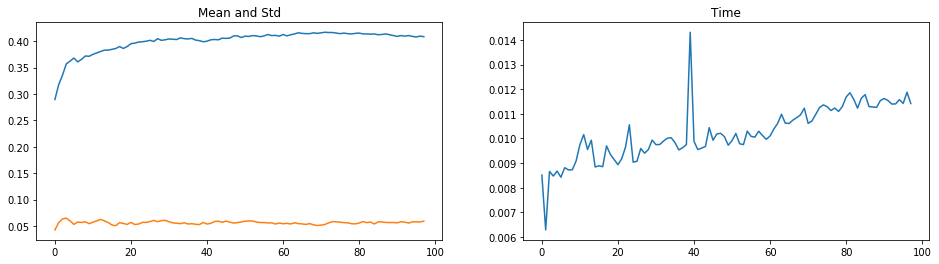

In [47]:
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata)
results_mean = []
results_std = []
time_taken = []

for i in range(2, 100):
    classifier = KNeighborsClassifier(i, algorithm="brute", weights = 'distance')
    start = time.time()
    scores = cross_val_score(classifier, X_minmax, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)
    

plt.figure(figsize=(16,4))    
plt.subplot(1,2,1)
plt.plot(results_mean)
plt.plot(results_std)
plt.title("Mean and Std")
plt.subplot(1,2,2)
plt.plot(time_taken)
plt.title("Time")

#### Naive Bayes

In [13]:
Xdata = drugs.iloc[:,1:13]
Ydata = drugs.cannabis

rfc = RandomForestClassifier(n_estimators=10)
cross_val_score(rfc, Xdata, Ydata, cv=10)

ValueError: could not convert string to float: 'White'

             precision    recall  f1-score   support

          0       0.44      0.73      0.55       413
          1       0.24      0.10      0.14       207
          2       0.17      0.08      0.11       266
          3       0.16      0.03      0.05       211
          4       0.00      0.00      0.00       140
          5       0.00      0.00      0.00       185
          6       0.38      0.78      0.51       463

avg / total       0.26      0.38      0.28      1885



/home/niklas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


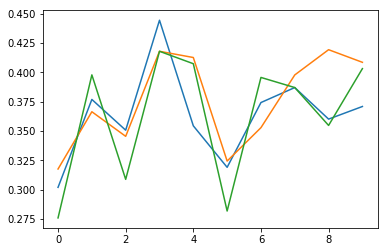

In [73]:
###################### naive bayes

### preprocessing
Xdata = drugs.iloc[:,1:13]
Ydata = drugs.cannabis
#discretize continuis variables
for i in range(5,Xdata.shape[1]):
    quantiles = Xdata.iloc[:,i].quantile([0,0.2,0.4,0.6,0.8,1])
    Xdata.iloc[:,i] = pd.cut(Xdata.iloc[:,i], quantiles, include_lowest=True)

Xdata_lable = Xdata

for i in range(0,12):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata.iloc[:,i])
 
    
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()
predicts_mnb = cross_val_predict(mnb, Xdata_lable, Ycannabis, cv=10)
scores_mnb = cross_val_score(mnb, Xdata_lable, Ycannabis, cv=10)
scores_bnb = cross_val_score(bnb, Xdata_lable, Ycannabis, cv=10)
scores_gnb = cross_val_score(gnb, Xdata_lable, Ycannabis, cv=10)
plt.plot(scores_bnb)
plt.plot(scores_mnb)
plt.plot(scores_gnb)
print(classification_report(Ycannabis, predicts_mnb))

In [34]:
conf = confusion_matrix(Ycannabis, predicts_mnb)
(conf/conf.sum(0)).round(3)

array([[0.488, 0.254, 0.191, 0.105, 0.091, 0.071, 0.033],
       [0.167, 0.348, 0.16 , 0.04 , 0.   , 0.   , 0.025],
       [0.193, 0.123, 0.213, 0.218, 0.136, 0.048, 0.072],
       [0.058, 0.101, 0.156, 0.145, 0.227, 0.071, 0.138],
       [0.018, 0.029, 0.058, 0.065, 0.136, 0.071, 0.134],
       [0.017, 0.043, 0.093, 0.121, 0.227, 0.19 , 0.163],
       [0.058, 0.101, 0.129, 0.306, 0.182, 0.548, 0.436]])

Suggest to evaluate models with confusion matrix and cross vlidation
#### Random Forest

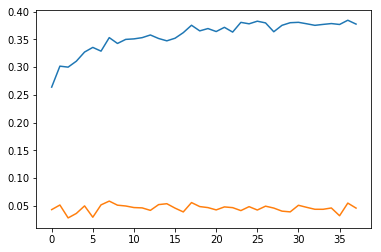

In [70]:
results_mean = []
results_std = []
time_taken = []

for i in range(2, 40):
    rfc = RandomForestClassifier(n_estimators=i)
    start = time.time()
    scores = cross_val_score(rfc, Xdata_lable, Ycannabis, cv=10)
    end = time.time()
    results_mean.append(scores.mean())
    results_std.append(scores.std())
    time_taken.append((end-start)/10)


plt.plot(results_mean)
plt.plot(results_std)